In [120]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import pickle
import joblib
%matplotlib inline

In [130]:
item_merged = pd.read_csv('data/filt/item_merged_15.csv')
item_merged.head(5)

,mainCategory,mainCategoryName,categoryId,categoryName,itemId,title,Price,galleryURL,viewItemURL
0,101,Apparel_Accessories,169291,Women's Bags & Handbags,1.450750e+11,Christian Dior Large Book Tote - Blue Multicol...,3300.00,https://i.ebayimg.com/thumbs/images/g/FgUAAOSw...,https://www.ebay.com/itm/Christian-Dior-Large-...
1,101,Apparel_Accessories,15709,Athletic Shoes,1.757200e+11,Size 9 - Nike Air Max Penny 1 Orlando,209.99,https://i.ebayimg.com/thumbs/images/g/6JsAAOSw...,https://www.ebay.com/itm/Size-9-Nike-Air-Max-P...
2,101,Apparel_Accessories,63861,Dresses,3.348680e+11,Mela Loves London dress size 8 blue and black ...,2.99,https://i.ebayimg.com/thumbs/images/g/qOsAAOSw...,https://www.ebay.com/itm/Mela-Loves-London-dre...
3,101,Apparel_Accessories,15709,Athletic Shoes,2.956910e+11,jordan 5,30.00,https://i.ebayimg.com/thumbs/images/g/x4EAAOSw...,https://www.ebay.com/itm/jordan-5-/295690696093
4,101,Apparel_Accessories,11554,Jeans,3.856050e+11,Out Jeans Women’s Flap Back Pocket Stretch Str...,10.00,https://i.ebayimg.com/thumbs/images/g/A9EAAOSw...,https://www.ebay.com/itm/Out-Jeans-Women-s-Fla...


In [123]:
item_merged['title'].apply(lambda x: len(x.split(' '))).sum()

238959

In [105]:
# mainCategoryName = ['java','html','asp.net','c#','ruby-on-rails','jquery','mysql','php','ios','javascript','python','c','css','android','iphone','sql','objective-c','c++','angularjs','.net']
# plt.figure(figsize=(10,4))
# df.tags.value_counts().plot(kind='bar');

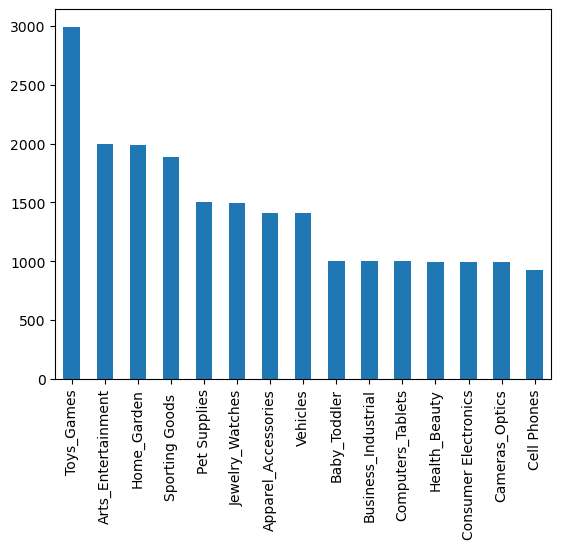

In [131]:
item_merged.mainCategoryName.value_counts().plot(kind='bar');

In [132]:
def print_plot(index):
    example = item_merged[item_merged.index == index][['title', 'mainCategoryName']].values[0]
    if len(example) > 0:
        print(example[0])
        print('mainCategoryName:', example[1])

In [133]:
print_plot(10)

Coach Daisy Spectator Emma Tote in Tan, Orange, and Pink Colorway 23922
mainCategoryName: Apparel_Accessories


#### Data Cleaning

In [134]:
space = re.compile('[/(){}\[\]\|@,;]')
symbols = re.compile('[^0-9a-z #+_]')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = space.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = symbols.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in stop_words) # delete stopwors from text
    return text

In [135]:
item_merged['title'] = item_merged['title'].apply(clean_text)

C:\Users\HyeOL\AppData\Local\Temp\ipykernel_20520\2407084109.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text # HTML decoding


In [136]:
item_merged['title'].apply(lambda x: len(x.split(' '))).sum()

224145

In [137]:
X = item_merged['title']
y = item_merged['mainCategoryName']

In [138]:
y.value_counts(normalize = True)

Toys_Games              0.138746
Arts_Entertainment      0.092358
Home_Garden             0.091988
Sporting Goods          0.087492
Pet Supplies            0.069466
Jewelry_Watches         0.069419
Apparel_Accessories     0.065434
Vehicles                0.065341
Baby_Toddler            0.046249
Business_Industrial     0.046249
Computers_Tablets       0.046249
Health_Beauty           0.046156
Consumer Electronics    0.046110
Cameras_Optics          0.046110
Cell Phones             0.042634
Name: mainCategoryName, dtype: float64

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=77)

In [224]:
X_train.shape, X_test.shape

((14457,), (7122,))

In [115]:
# ss = StandardScaler()
# Xs_train = ss.fit_transform(X_train)
# Xs_test = ss.transform(X_test)

#### Naive Bayes classifier

In [140]:
mnb = Pipeline([('cv', CountVectorizer()),
               ('tfidt', TfidfTransformer()),
               ('mnb', MultinomialNB()),
              ])

In [141]:
mnb.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('tfidt', TfidfTransformer()),
                ('mnb', MultinomialNB())])

In [142]:
mnb_model = mnb.fit(X_train, y_train)

In [143]:
%%time

y_pred = mnb.predict(X_test)

CPU times: total: 0 ns
Wall time: 88.9 ms


In [144]:
mnb.score(X_train, y_train), mnb.score(X_test, y_test)

(0.9306910147333471, 0.8590283628194327)

In [145]:
cross_val_score(mnb, X_train, y_train).mean()

0.8535664888361983

In [146]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print("mnb", classification_report(y_test, y_pred))

accuracy 0.8590283628194327
mnb                       precision    recall  f1-score   support

 Apparel_Accessories       0.95      0.94      0.94       466
  Arts_Entertainment       0.86      0.89      0.87       658
        Baby_Toddler       0.98      0.71      0.82       329
 Business_Industrial       0.93      0.50      0.65       329
      Cameras_Optics       0.97      0.77      0.86       328
         Cell Phones       0.96      0.93      0.94       304
   Computers_Tablets       0.84      0.74      0.79       329
Consumer Electronics       0.86      0.59      0.70       329
       Health_Beauty       0.98      0.74      0.84       329
         Home_Garden       0.78      0.87      0.82       655
     Jewelry_Watches       0.96      0.98      0.97       495
        Pet Supplies       0.92      0.96      0.94       495
     Sporting Goods        0.94      0.89      0.91       623
          Toys_Games       0.69      0.97      0.81       988
            Vehicles       0.85      

In [147]:
# text_model_mnb = pickle.dumps(mnb_model)

In [148]:
pickle.dump(mnb_model, open('text_model_mnb.pkl', 'wb'))

In [149]:
joblib.dump(mnb_model, "text_model_mnb.joblib", compress=0) 

['text_model_mnb.joblib']

In [150]:
mnb_model_p = pickle.load(open('text_model_mnb.pkl', 'rb'))

In [151]:
mnb_model_p.predict(X_test)

array(['Cell Phones', 'Cell Phones', 'Jewelry_Watches', ..., 'Toys_Games',
       'Sporting Goods ', 'Home_Garden'], dtype='<U20')

#### Linear support vector machine

In [152]:
from sklearn.linear_model import SGDClassifier

In [153]:
sgd = Pipeline([('cv', CountVectorizer()),
                ('tfidt', TfidfTransformer()),
                ('sgd', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=77, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('tfidt', TfidfTransformer()),
                ('sgd',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=77,
                               tol=None))])

In [154]:
%%time

y_pred = sgd.predict(X_test)

CPU times: total: 15.6 ms
Wall time: 76.8 ms


In [155]:
sgd.score(X_train, y_train), sgd.score(X_test, y_test)

(0.9424500242097253, 0.8740522325189554)

In [156]:
cross_val_score(sgd, X_train, y_train).mean()

0.8768774223241586

In [157]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print("sgd", classification_report(y_test, y_pred))

accuracy 0.8740522325189554
sgd                       precision    recall  f1-score   support

 Apparel_Accessories       0.91      0.95      0.93       466
  Arts_Entertainment       0.86      0.88      0.87       658
        Baby_Toddler       0.85      0.82      0.83       329
 Business_Industrial       0.89      0.59      0.71       329
      Cameras_Optics       0.86      0.86      0.86       328
         Cell Phones       0.93      0.93      0.93       304
   Computers_Tablets       0.79      0.81      0.80       329
Consumer Electronics       0.83      0.66      0.74       329
       Health_Beauty       0.90      0.82      0.86       329
         Home_Garden       0.83      0.84      0.83       655
     Jewelry_Watches       0.91      0.99      0.95       495
        Pet Supplies       0.90      0.97      0.93       495
     Sporting Goods        0.93      0.90      0.92       623
          Toys_Games       0.88      0.91      0.90       988
            Vehicles       0.82      

In [158]:
text_model_sgd = pickle.dumps(sgd)

#### Logistic regression

In [159]:
from sklearn.linear_model import LogisticRegression

In [215]:
lgr = Pipeline([('cv', CountVectorizer()),
                ('tfidt', TfidfTransformer()),
                ('lgr', LogisticRegression(n_jobs=1, C=1e5))
               ])

In [216]:
lgr.fit(X_train, y_train)

C:\Users\HyeOL\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('cv', CountVectorizer()), ('tfidt', TfidfTransformer()),
                ('lgr', LogisticRegression(C=100000.0, n_jobs=1))])

In [217]:
lgr_model = lgr.fit(X_train, y_train)

C:\Users\HyeOL\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [218]:
%%time

y_pred = lgr.predict(X_test)

CPU times: total: 62.5 ms
Wall time: 129 ms


In [219]:
lgr.score(X_train, y_train), lgr.score(X_test, y_test)

(1.0, 0.9151923616961528)

In [220]:
cross_val_score(lgr, X_train, y_train).mean()

C:\Users\HyeOL\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\HyeOL\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

0.9120850562603551

In [221]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print("lgr", classification_report(y_test, y_pred))

accuracy 0.9151923616961528
lgr                       precision    recall  f1-score   support

 Apparel_Accessories       0.95      0.98      0.96       465
  Arts_Entertainment       0.91      0.91      0.91       658
        Baby_Toddler       0.91      0.90      0.90       331
 Business_Industrial       0.79      0.75      0.77       306
      Cameras_Optics       0.92      0.90      0.91       314
         Cell Phones       0.94      0.96      0.95       309
   Computers_Tablets       0.86      0.83      0.84       337
Consumer Electronics       0.80      0.81      0.80       336
       Health_Beauty       0.91      0.93      0.92       350
         Home_Garden       0.91      0.89      0.90       662
     Jewelry_Watches       0.98      0.97      0.98       467
        Pet Supplies       0.95      0.96      0.95       496
     Sporting Goods        0.95      0.93      0.94       641
          Toys_Games       0.91      0.94      0.93       978
            Vehicles       0.93      

In [222]:
pickle.dump(lgr_model, open('text_model_lgr.pkl', 'wb'))

### KNN + GridSearch

In [186]:
knn = KNeighborsClassifier()
cvec = CountVectorizer()

In [187]:
gs_params = {
    'cvec__max_features': [2000,5000,10000],
    'cvec__min_df': [2,3],
    'cvec__max_df': [.9,.95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__stop_words': ['english', None]
}

In [188]:
pipe_knn = Pipeline([
    ('cvec', cvec),
    ('knn', knn)
])

In [189]:
knn_gs = GridSearchCV(pipe_knn, 
                      gs_params, 
                      cv =5)

In [190]:
knn_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 5000, 10000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': ['english', None]})

In [191]:
knn_gs.score(X_train, y_train), knn_gs.score(X_test, y_test)

(0.8330220654354292, 0.7389778152204437)

In [193]:
def param_score(model):
    print(f"Train Score: {model.score(X_train, y_train)}")
    print(f"Cross_Val_Score: {cross_val_score(model, X_train, y_train).mean()}")
    print(f"Test Score: {model.score(X_test, y_test)}\n")

    print(f"Best Score: {model.best_score_}")    
    for param, value in model.best_params_.items():
        print(f"Best_params {param}: {value}")
        
    print(f"RMSE: {mean_squared_error(y_test, model.predict(X_test))**0.5}\n")

In [ ]:
param_score(knn_gs)

In [197]:
best_cvec = CountVectorizer(max_df = 0.9,
                             max_features = 2000,
                             min_df = 2,
                             ngram_range = (1, 1))

In [198]:
knn_best = Pipeline([
    ('cvec', best_cvec),
    ('knn', knn)
])

In [199]:
knn_best.fit(X_train, y_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=2000, min_df=2)),
                ('knn', KNeighborsClassifier())])

In [200]:
knn_model = knn_best.fit(X_train, y_train)

In [201]:
knn_best.score(X_train, y_train), knn_best.score(X_test, y_test)

(0.816490281524521, 0.7280258354394833)

In [202]:
cross_val_score(knn_best, X_train, y_train).mean()

0.6885941393928695

In [203]:
%%time

pred = knn_best.predict(X_test)

CPU times: total: 2.38 s
Wall time: 3.34 s


In [204]:
pred

array(['Cell Phones', 'Cell Phones', 'Jewelry_Watches', ..., 'Toys_Games',
       'Sporting Goods ', 'Home_Garden'], dtype=object)

In [205]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print("knn_best", classification_report(y_test, y_pred))

accuracy 0.6429373771412524
knn_best                       precision    recall  f1-score   support

 Apparel_Accessories       0.93      0.85      0.89       466
  Arts_Entertainment       0.53      0.62      0.57       658
        Baby_Toddler       0.70      0.59      0.64       329
 Business_Industrial       0.74      0.45      0.56       329
      Cameras_Optics       0.63      0.54      0.58       328
         Cell Phones       1.00      0.92      0.96       304
   Computers_Tablets       0.56      0.40      0.47       329
Consumer Electronics       0.55      0.22      0.32       329
       Health_Beauty       1.00      0.62      0.77       329
         Home_Garden       0.51      0.50      0.50       655
     Jewelry_Watches       0.90      0.82      0.86       495
        Pet Supplies       0.86      0.75      0.80       495
     Sporting Goods        0.83      0.77      0.80       623
          Toys_Games       0.40      0.68      0.50       988
            Vehicles       0.59 

In [206]:
pickle.dump(knn_model, open('text_model_knn.pkl', 'wb'))

#### Word2vec embedding + Random Forest

In [168]:
from gensim.models import Word2Vec

In [169]:
w2v = Word2Vec(X_train, 
               vector_size = 100, 
               window=5,
               min_count=2)

print(w2v)

Word2Vec<vocab=40, vector_size=100, alpha=0.025>


In [170]:
w2v.wv.index_to_key

[' ',
 'e',
 'a',
 'r',
 't',
 's',
 'o',
 'i',
 'n',
 'l',
 'c',
 'd',
 'p',
 'm',
 'g',
 'h',
 'u',
 'b',
 'f',
 'w',
 'k',
 'y',
 '0',
 '1',
 '2',
 'v',
 '5',
 'x',
 '4',
 '3',
 '6',
 '9',
 '8',
 'z',
 'j',
 '7',
 'q',
 '#',
 '+',
 '_']

In [171]:
words = set(w2v.wv.index_to_key)

X_train_vect = np.array([np.array([w2v.wv[i] for i in ls if i in words])
                         for ls in X_train])
X_test_vect = np.array([np.array([w2v.wv[i] for i in ls if i in words])
                         for ls in X_test])

C:\Users\HyeOL\AppData\Local\Temp\ipykernel_20520\4144722337.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([w2v.wv[i] for i in ls if i in words])
C:\Users\HyeOL\AppData\Local\Temp\ipykernel_20520\4144722337.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect = np.array([np.array([w2v.wv[i] for i in ls if i in words])


In [172]:
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))

In [173]:
for i, v in enumerate(X_train_vect_avg):
    print(len(X_train.iloc[i]), len(v))

46 100
67 100
78 100
64 100
32 100
51 100
72 100
78 100
66 100
70 100
65 100
52 100
76 100
33 100
78 100
71 100
68 100
55 100
45 100
73 100
67 100
74 100
80 100
74 100
78 100
69 100
78 100
73 100
74 100
51 100
72 100
55 100
74 100
43 100
70 100
77 100
47 100
68 100
43 100
47 100
67 100
44 100
78 100
78 100
56 100
75 100
33 100
40 100
53 100
79 100
77 100
53 100
75 100
71 100
66 100
80 100
67 100
74 100
80 100
65 100
25 100
75 100
77 100
57 100
79 100
14 100
77 100
75 100
72 100
40 100
48 100
48 100
71 100
74 100
41 100
62 100
67 100
75 100
72 100
73 100
68 100
67 100
75 100
77 100
73 100
74 100
73 100
75 100
64 100
75 100
65 100
79 100
75 100
56 100
70 100
70 100
79 100
61 100
79 100
69 100
76 100
77 100
45 100
60 100
76 100
78 100
69 100
68 100
77 100
72 100
72 100
62 100
63 100
57 100
68 100
30 100
65 100
75 100
79 100
68 100
69 100
80 100
59 100
66 100
65 100
56 100
43 100
73 100
80 100
66 100
68 100
76 100
69 100
76 100
77 100
66 100
20 100
61 100
76 100
52 100
53 100
74 100
76 100

In [174]:
from sklearn.ensemble import RandomForestClassifier

In [175]:
rf = RandomForestClassifier()
rf.fit(X_train_vect_avg, y_train.values.ravel())

RandomForestClassifier()

In [176]:
rf_model = rf.fit(X_train_vect_avg, y_train.values.ravel())

In [177]:
y_pred = rf.predict(X_test_vect_avg)

In [178]:
rf.score(X_train_vect_avg, y_train), rf.score(X_test_vect_avg, y_test)

(1.0, 0.6429373771412524)

In [179]:
cross_val_score(sgd, X_train, y_train).mean()

0.8768774223241586

In [180]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print("w2v+rf", classification_report(y_test, y_pred))

accuracy 0.6429373771412524
w2v+rf                       precision    recall  f1-score   support

 Apparel_Accessories       0.93      0.85      0.89       466
  Arts_Entertainment       0.53      0.62      0.57       658
        Baby_Toddler       0.70      0.59      0.64       329
 Business_Industrial       0.74      0.45      0.56       329
      Cameras_Optics       0.63      0.54      0.58       328
         Cell Phones       1.00      0.92      0.96       304
   Computers_Tablets       0.56      0.40      0.47       329
Consumer Electronics       0.55      0.22      0.32       329
       Health_Beauty       1.00      0.62      0.77       329
         Home_Garden       0.51      0.50      0.50       655
     Jewelry_Watches       0.90      0.82      0.86       495
        Pet Supplies       0.86      0.75      0.80       495
     Sporting Goods        0.83      0.77      0.80       623
          Toys_Games       0.40      0.68      0.50       988
            Vehicles       0.59   

In [96]:
# from sklearn.metrics import precision_score, recall_score

In [100]:
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# print('Precision: {} / Recall: {} / Accuracy: {}'.format(
#     round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

In [181]:
pickle.dump(rf_model, open('text_model_wbrf.pkl', 'wb'))

In [110]:
# text_model_wv_rf = pickle.dumps(rf_model)

In [120]:
joblib.dump(rf_model, "text_model_wv_rf.joblib", compress=0)

['text_model_wv_rf.joblib']